In [180]:
# --------- import required functions

from tensorflow.keras.layers import *
import pandas as pd



from tensorflow.keras.layers import *
from glob import glob
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
from tensorflow.keras.utils import CustomObjectScope

from skimage.measure import label, regionprops

In [2]:
# -------------dice and dice_loss 
def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float64')
    y_pred = K.cast(y_pred, 'float64')
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union        = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice         = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
  return 1.-dice_coef(y_true, y_pred)


# ----------build_unet  
class CONV:
    def conv_block(data, base, batchnorm=False):
        # --------------- 1st block
        x = Conv2D(filters=base, kernel_size=(3, 3), padding='same')(data)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # --------------- 2nd block
        x = Conv2D(filters=base, kernel_size=(3, 3), padding='same')(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

def build_unet(h, w, c, base, classes, dropout=True, batchnorm=True):
    num_filters = [base, base * 2, base * 4, base * 8]
    inputs = Input((h, w, c))

    skip_x = []
    x = inputs

    # ----------------- Encoder
    for f in num_filters:
        x = CONV.conv_block(x, f, batchnorm=True)
        skip_x.append(x)
        x = MaxPooling2D(pool_size=(2, 2), padding="same")(x)
        if dropout:
            x = Dropout(0.2)(x)

            # ----------------- Bridge
    x = CONV.conv_block(x, num_filters[-1], batchnorm=True)
    # x = MaxPooling2D(pool_size=(2, 2), padding="same") (x)  # no need to this layer
    if dropout:
        x = Dropout(0.2)(x)

    num_filters.reverse()
    skip_x.reverse()

    # ----------------- Decoder
    for i, f in enumerate(num_filters):
        #x = UpSampling2D((2, 2))(x)  # Conv2DTranspose(f, (2,2)) (x)
        x = Conv2DTranspose(filters=f, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
        xs = skip_x[i]
        #height, width = determine_crop(xs, x)
        #crop_xs = Cropping2D(cropping=(height, width))(xs)
        x = Concatenate()([x, xs])
        if dropout:
            x = Dropout(0.2)(x)
        x = CONV.conv_block(x, f, batchnorm=True)

    # ----------------- Output
    out = Conv2D(classes, (1, 1), padding="same", activation='sigmoid')(x)

    # ----------------- input and output
    model = Model(inputs=inputs, outputs=out)
    model.summary()
    return model





In [38]:
modelFilePath = "/media/Tomasz/4T/work/keel/dataset/output/output_fold_1"
#mainPath="I:\\download\\deepLearning\\datasets\\keelYolo\\keelTwoCalssesDataset"
mainPath="/media/Tomasz/4T/work/keel/dataset"
#workDir = "imagesKeelBatch2/"
workDir = "onlyBatch2/"
outDir = "cutOffByMaskOutput"
workPath = os.path.join(mainPath,workDir)
outPath = os.path.join(mainPath,outDir)

In [4]:
#model = tf.keras.models.load_model(os.path.join(modelFilePath, 'model.h5'), compile=False)
#model.compile()
lr = 0.0001
loss = "binary_crossentropy"
metrics = ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), dice_coef]
model = tf.keras.models.load_model(os.path.join(modelFilePath, 'model.h5'), compile=False)
model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=metrics)
#model = tf.keras.models.load_model(os.path.join(modelFilePath, 'model.h5'))

2024-12-19 23:37:49.428723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-19 23:37:49.440244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-19 23:37:49.440451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-19 23:37:49.444857: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-19 23:37:49.445085: I external/local_xla/xla/stream_executor

In [7]:
def image_normalization(img, img_min=0, img_max=255):
    """This is a typical image normalization function
    where the minimum and maximum of the image is needed
    source: https://en.wikipedia.org/wiki/Normalization_(image_processing)
    :param img: an image could be gray scale or color
    :param img_min:  for default is 0
    :param img_max: for default is 255
    :return: a normalized image, if max is 255 the dtype is uint8
    """
    img = np.float32(img)
    epsilon=1e-12 # whenever an inconsistent image
    img = (img-np.min(img))*(img_max-img_min)/((np.max(img)-np.min(img))+epsilon)+img_min
    return img

(2260, 1748)


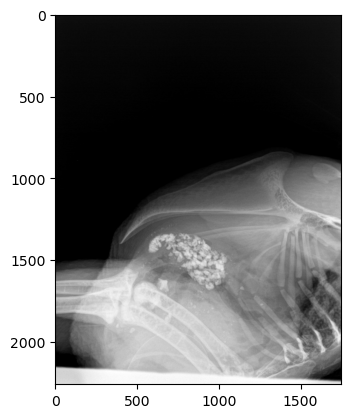

In [119]:

input_path = os.path.join(workPath, "02023SG1018_batch2_brown_ok_2.jpg")
input_path = os.path.join(workPath, "02023SG1005_batch2_brown_ok_0.jpg")

imageOne = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
print(imageOne.shape)
plt.imshow(imageOne, cmap="gray")


1/1 [==============================] - 0s 38ms/step


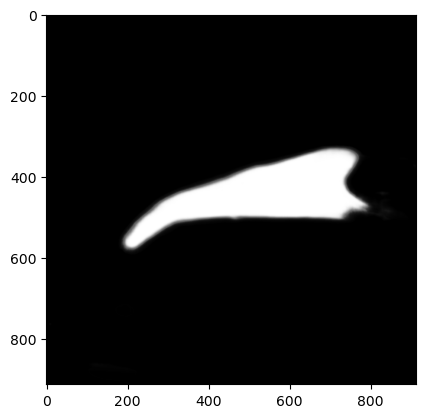

In [120]:

n=0
#for z in dataset_:
   # n=n+1
#input_path = os.path.join(workPath, "edged_02023SG3_batch2_brown_ok_0.jpg")
image=imageOne
image = image/255.0 # normalization
image = image.astype(np.float32)
image = cv2.resize(image, (912,912))
image = np.expand_dims(image, axis=0)
#plt.imshow(image)

res_pre = model.predict(image)
res = res_pre[-1,:,:]
#res *= 255.0
plt.imshow(res,cmap="gray")
    #fullpath = os.path.join(outPath, 'masked_'+str(n))
    #cv2.imwrite(fullpath, res_pre)


Found bbox (332, 194, 577, 792)   61372.0


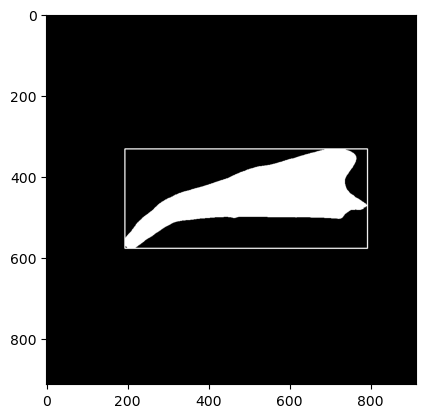

In [171]:

# from skimage.morphology import label
res2=image_normalization(res)
res2[res2 < 0.0] = 0.0
#out=cv2.bitwise_not(np.uint8(image_normalization(res2)))


mask_0 = res2
thresh = 127
mask_0 = cv2.threshold(mask_0, thresh, 255, cv2.THRESH_BINARY)[1]
mask_1 = mask_0
lbl_0 = label(mask_1) 
props = regionprops(lbl_0)
p=0
maxArea=-99999
maxIndex=0
x=y=w=h=0
for prop in props:
    print('Found bbox', prop.bbox, " ", prop.area)
    if(prop.area>maxArea):
        maxArea = prop.area
        maxIndex = p


    p=p+1
x = props[maxIndex].bbox[1]
y = props[maxIndex].bbox[0]
w = props[maxIndex].bbox[3]
h = props[maxIndex].bbox[2]
cv2.rectangle(mask_0, (x, y), (w, h), (255, 0, 0), 2)
plt.imshow(mask_0, cmap="gray")

cv2.rectangle(mask_0, (x, y), (w, h), (0, 0, 0), 2)
onlyMaskImage = mask_0[y:h, x:w]



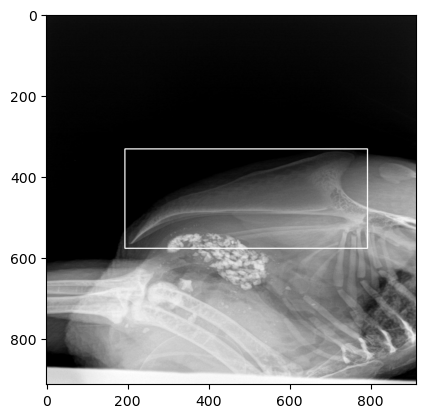

In [172]:
imageOneResized = cv2.resize(imageOne, (912,912))

cv2.rectangle(imageOneResized, (x, y), (w, h), (255, 0, 0), 2)
plt.imshow(imageOneResized, cmap="gray")

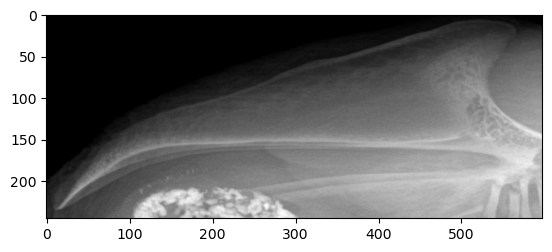

In [173]:
imageOneResized = cv2.resize(imageOne, (912,912))
onlyKeelImage = imageOneResized[y:h, x:w]
plt.imshow(onlyKeelImage, cmap="gray")

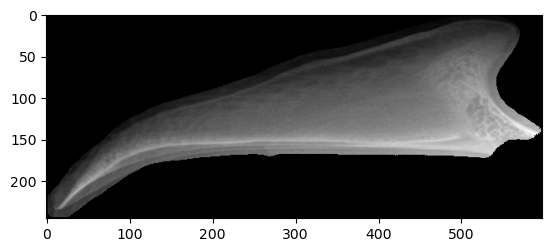

In [179]:
#masked = cv2.bitwise_and(np.array(onlyKeelImage), np.array(onlyMaskImage))
masked = np.array(onlyKeelImage) * np.array(onlyMaskImage/255)
plt.imshow(masked, cmap="gray")


In [178]:
fullpath = os.path.join(outPath, "2.jpg")
cv2.imwrite(fullpath, masked)

True

In [205]:
def predict_mask(image_in):
    image=image_in
    image = image/255.0 # normalization
    image = image.astype(np.float32)
    image = cv2.resize(image, (912,912))
    image = np.expand_dims(image, axis=0)
    res_pre = model.predict(image)
    res = res_pre[-1,:,:]
    return res

def get_rectangle_with_bigest_mask(mask_in):
    res2=image_normalization(mask_in)
    res2[res2 < 0.0] = 0.0
    mask_0 = res2
    thresh = 127
    mask_0 = cv2.threshold(mask_0, thresh, 255, cv2.THRESH_BINARY)[1]
    mask_1 = mask_0
    lbl_0 = label(mask_1) 
    props = regionprops(lbl_0)
    p=0
    maxArea=-99999
    maxIndex=0
    x=y=w=h=0
    
    for prop in props:
        #print('Found bbox', prop.bbox, " ", prop.area)
        if(prop.area>maxArea):
            maxArea = prop.area
            maxIndex = p


        p=p+1
        
    x = props[maxIndex].bbox[1]
    y = props[maxIndex].bbox[0]
    w = props[maxIndex].bbox[3]
    h = props[maxIndex].bbox[2]

    onlyMaskImage = mask_0[y:h, x:w]
    
    return x,y,w,h,onlyMaskImage
    
def get_rectangle_from_original_image(x,y,w,h,imageOne,iw,ih):
    imageOneResized = cv2.resize(imageOne, (iw,ih))
    onlyKeelImage = imageOneResized[y:h, x:w]

    return onlyKeelImage

In [209]:
imageList = glob(os.path.join(workPath,"*"))
for n in range(len(imageList)):
    input_path = imageList[n]
    filename = os.path.basename(imageList[n])
    imageOne = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

    predicted_mask = predic_mask(imageOne)


    x,y,w,h,mask_rect = get_rectangle_with_bigest_mask(predicted_mask)
    print(x,y,w,h)
    predicted_keel = get_rectangle_from_original_image(x,y,w,h,imageOne,912,912)
    #plt.imshow(predicted_mask)
    out = np.array(predicted_keel) * np.array(mask_rect/255)
    fullpath = os.path.join(outPath, filename)
    cv2.imwrite(fullpath, out)


1/1 [==============================] - 0s 36ms/step
150 267 897 440
1/1 [==============================] - 0s 36ms/step
150 340 802 519
1/1 [==============================] - 0s 36ms/step
184 402 684 545
1/1 [==============================] - 0s 35ms/step
240 437 795 576
1/1 [==============================] - 0s 37ms/step
204 415 741 562
1/1 [==============================] - 0s 36ms/step
138 131 756 412
1/1 [==============================] - 0s 37ms/step
226 437 753 579
1/1 [==============================] - 0s 36ms/step
181 412 712 544
1/1 [==============================] - 0s 44ms/step
158 357 689 497
1/1 [==============================] - 0s 35ms/step
278 409 793 538
1/1 [==============================] - 0s 38ms/step
109 369 671 505
1/1 [==============================] - 0s 38ms/step
200 147 718 299
1/1 [==============================] - 0s 36ms/step
121 372 620 513
1/1 [==============================] - 0s 37ms/step
206 418 893 614
1/1 [==============================] - 0s 42ms/s